# Fit Pooping Cloud model to GMCs - HII Regions 2-point Cross-Correlation Functions of PHANGS Galaxies

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import astropy.io.fits as fits
import astropy.io.ascii as ascii
from astropy import wcs
from astropy.coordinates import SkyCoord
from photutils import SkyCircularAperture
from photutils import aperture_photometry
import astropy.units as u
from reproject import reproject_interp
from scipy.interpolate import NearestNDInterpolator
import time

np.random.seed(666)

## Name of galaxy

In [5]:
#galaxy='IC5332'
galaxy='NGC0628'
#galaxy='NGC1087'
#galaxy='NGC1365' 
#galaxy='NGC1512'
#galaxy='NGC1672'
#galaxy='NGC2835'
#galaxy='NGC3351'
#galaxy='NGC3627'
#galaxy='NGC5068'


## Routine to Make GMC+HII Region Realization of Random Pooping Cloud Model

In [ ]:
# Random Pooping Cloud Model
# function returns x,y coordinates of HII regions within a box Dx,Dy 
# Parameters:
# l [pc] = characteristic distance between regions
# tc [Myr] = cloud lifetime
# tfb [Myr] = feedback time (i.e. time between last SF event and dissipation of GMC)
# ts [Myr] = HII region lifetime (i.e. time between SF event and death of ionizing massive stars)
# Ng = number of generations of massive stars formed during GMC lifetime
# vs [km/s] = characteristic velocity of massive stars wrt GMC 
# rc [pc] = characteristic GMC radius (HII regions only seen when they reach it)


def pooprand(galaxy, tc=30, tfb=4, ts=10, Ng=2, vs=10, rc=20, l=100, plot=False, verbose=False):
    
    # Number of GMCs, their random coordinates and ages, and on/off (1/0) flag
#    Ngmc=round(Dx*Dy/l**2) 
    Ngmc=len(xgmc)
#    xgmc=np.random.uniform(-(Dx/2), Dx/2, Ngmc)
#    ygmc=np.random.uniform(-(Dx/2), Dx/2, Ngmc)
    tmax=tc-tfb+ts
    t=np.random.uniform(0, tmax, Ngmc)
    fgmc=np.zeros(Ngmc, dtype=bool)
    fgmc[t<tc]=True
    
    # Number of HII regions born out of each GMC
    Nhii=np.floor(t*Ng/(tc-tfb)).astype(int)
    Nhii[Nhii > Ng]=Ng
    
    # Properties of each HII region
    Nhiitot=np.sum(Nhii) # total number of HII regioins
    if Nhiitot<2: # if no HII regions just make 2 random ones
        Nhii=np.zeros(Ngmc).astype(int)
        Nhii[np.random.choice(len(Nhii),2).astype(int)]=1
        Nhiitot=np.sum(Nhii).astype(int) # total number of HII regioins
    ind=np.zeros(Nhiitot) # parent GMC array index of HII region
    thii=np.zeros(Nhiitot) # time of birth
    dr=np.zeros(Nhiitot) # travelled distance from GMC
    dtheta=np.random.uniform(0, 2*np.pi, Nhiitot) # random angle setting direction of travel
    dphi=np.random.uniform(-np.pi/2, np.pi/2, Nhiitot) # random agnle setting out-of-plane direction of travel
    fhii=np.zeros(Nhiitot, dtype=bool) # on/off (1/0) flag

    k=0 # counter
    for i in range(Ngmc):
        for j in range(Nhii[i]):
            ind[k]=i
            thii[k]=(j+1)*(tc-tfb)/Ng   
            k=k+1
    ind=ind.astype(int)
    vs=vs*3.2e-14*(1e6*365*24*3600) # velocity in pc/Myr
    dr=vs*(t[ind]-thii)
    fhii[t[ind]<thii+ts]=True # HII region has not died
    if vs!=0: # only if vo=0 as SFUP assumes HII regions are seen as soon as they form
        fhii[t[ind]<thii+rc/vs]=False # HII region has left the GMC
    xhii=xgmc[ind]+dr*np.cos(dphi)*np.cos(dtheta)
    yhii=ygmc[ind]+dr*np.cos(dphi)*np.sin(dtheta)

    
    if verbose:
        print("Number of Parent Clouds = ", Ngmc)
        print("Number of Born HII regions", Nhiitot)    
        print("Number of Surviving Clouds = ", len(fgmc[fgmc]))
        print("Number of Surviving HII regions", len(fhii[fhii]))  
        print("Ngmc/Nhii Ratio", len(fgmc[fgmc])/len(fhii[fhii]))
        print("")
    
    if plot:
        fig1, ax1 = plt.subplots(figsize=(20, 20))
        #ax1.plot(xgmc, ygmc, '.b')
        #ax1.plot(xhii, yhii, '.r')
        ax1.plot(xgmc[fgmc], ygmc[fgmc], '.b', alpha=0.5)
        ax1.plot(xhii[fhii], yhii[fhii], '.r', alpha=0.5)
        plt.show()
    
    return (xgmc[fgmc], ygmc[fgmc], xhii[fhii], yhii[fhii])

## Routine to Make GMC+HII Region Realization of the Clustered Pooping Cloud Model

In [ ]:
# Random Pooping Cloud Model
# function returns x,y coordinates of HII regions within a box Dx,Dy 
# Parameters:
# l [pc] = characteristic distance between regions
# tc [Myr] = cloud lifetime
# tfb [Myr] = feedback time (i.e. time between last SF event and dissipation of GMC)
# ts [Myr] = HII region lifetime (i.e. time between SF event and death of ionizing massive stars)
# Ng = number of generations of massive stars formed during GMC lifetime
# vs [km/s] = characteristic velocity of massive stars wrt GMC 
# rc [pc] = characteristic GMC radius (HII regions only seen when they reach it)


def poopxy(xgmc, ygmc, tc=30, tfb=4, ts=10, Ng=2, vs=10, rc=20, plot=False, verbose=False):

    # Number of GMCs, their random coordinates and ages, and on/off (1/0) flag
#    Ngmc=round(Dx*Dy/l**2) 
    Ngmc=len(xgmc)
#    xgmc=np.random.uniform(-(Dx/2), Dx/2, Ngmc)
#    ygmc=np.random.uniform(-(Dx/2), Dx/2, Ngmc)
    tmax=tc-tfb+ts
    t=np.random.uniform(0, tmax, Ngmc)
    fgmc=np.zeros(Ngmc, dtype=bool)
    fgmc[t<tc]=True
    
    # Number of HII regions born out of each GMC
    Nhii=np.floor(t*Ng/(tc-tfb)).astype(int)
    Nhii[Nhii > Ng]=Ng
    
    # Properties of each HII region
    Nhiitot=np.sum(Nhii) # total number of HII regioins
    if Nhiitot<2: # if no HII regions just make 2 random ones
        Nhii=np.zeros(Ngmc).astype(int)
        Nhii[np.random.choice(len(Nhii),2).astype(int)]=1
        Nhiitot=np.sum(Nhii).astype(int) # total number of HII regioins
    ind=np.zeros(Nhiitot) # parent GMC array index of HII region
    thii=np.zeros(Nhiitot) # time of birth
    dr=np.zeros(Nhiitot) # travelled distance from GMC
    dtheta=np.random.uniform(0, 2*np.pi, Nhiitot) # random angle setting direction of travel
    dphi=np.random.uniform(-np.pi/2, np.pi/2, Nhiitot) # random agnle setting out-of-plane direction of travel
    fhii=np.zeros(Nhiitot, dtype=bool) # on/off (1/0) flag

    k=0 # counter
    for i in range(Ngmc):
        for j in range(Nhii[i]):
            ind[k]=i
            thii[k]=(j+1)*(tc-tfb)/Ng   
            k=k+1
    ind=ind.astype(int)
    vs=vs*3.2e-14*(1e6*365*24*3600) # velocity in pc/Myr
    dr=vs*(t[ind]-thii)
    fhii[t[ind]<thii+ts]=True # HII region has not died
    if vs!=0: # only if vo=0 as SFUP assumes HII regions are seen as soon as they form
        fhii[t[ind]<thii+rc/vs]=False # HII region has left the GMC
    xhii=xgmc[ind]+dr*np.cos(dphi)*np.cos(dtheta)
    yhii=ygmc[ind]+dr*np.cos(dphi)*np.sin(dtheta)

    
    if verbose:
        print("Number of Parent Clouds = ", Ngmc)
        print("Number of Born HII regions", Nhiitot)    
        print("Number of Surviving Clouds = ", len(fgmc[fgmc]))
        print("Number of Surviving HII regions", len(fhii[fhii]))  
        print("Ngmc/Nhii Ratio", len(fgmc[fgmc])/len(fhii[fhii]))
        print("")
    
    if plot:
        fig1, ax1 = plt.subplots(figsize=(20, 20))
        #ax1.plot(xgmc, ygmc, '.b')
        #ax1.plot(xhii, yhii, '.r')
        ax1.plot(xgmc[fgmc], ygmc[fgmc], '.b', alpha=0.5)
        ax1.plot(xhii[fhii], yhii[fhii], '.r', alpha=0.5)
        plt.show()
    
    return (xgmc[fgmc], ygmc[fgmc], xhii[fhii], yhii[fhii])

Number of Parent Clouds =  10000
Number of Born HII regions 2798
Number of Surviving Clouds =  8322
Number of Surviving HII regions 2798
Ngmc/Nhii Ratio 2.974267333809864



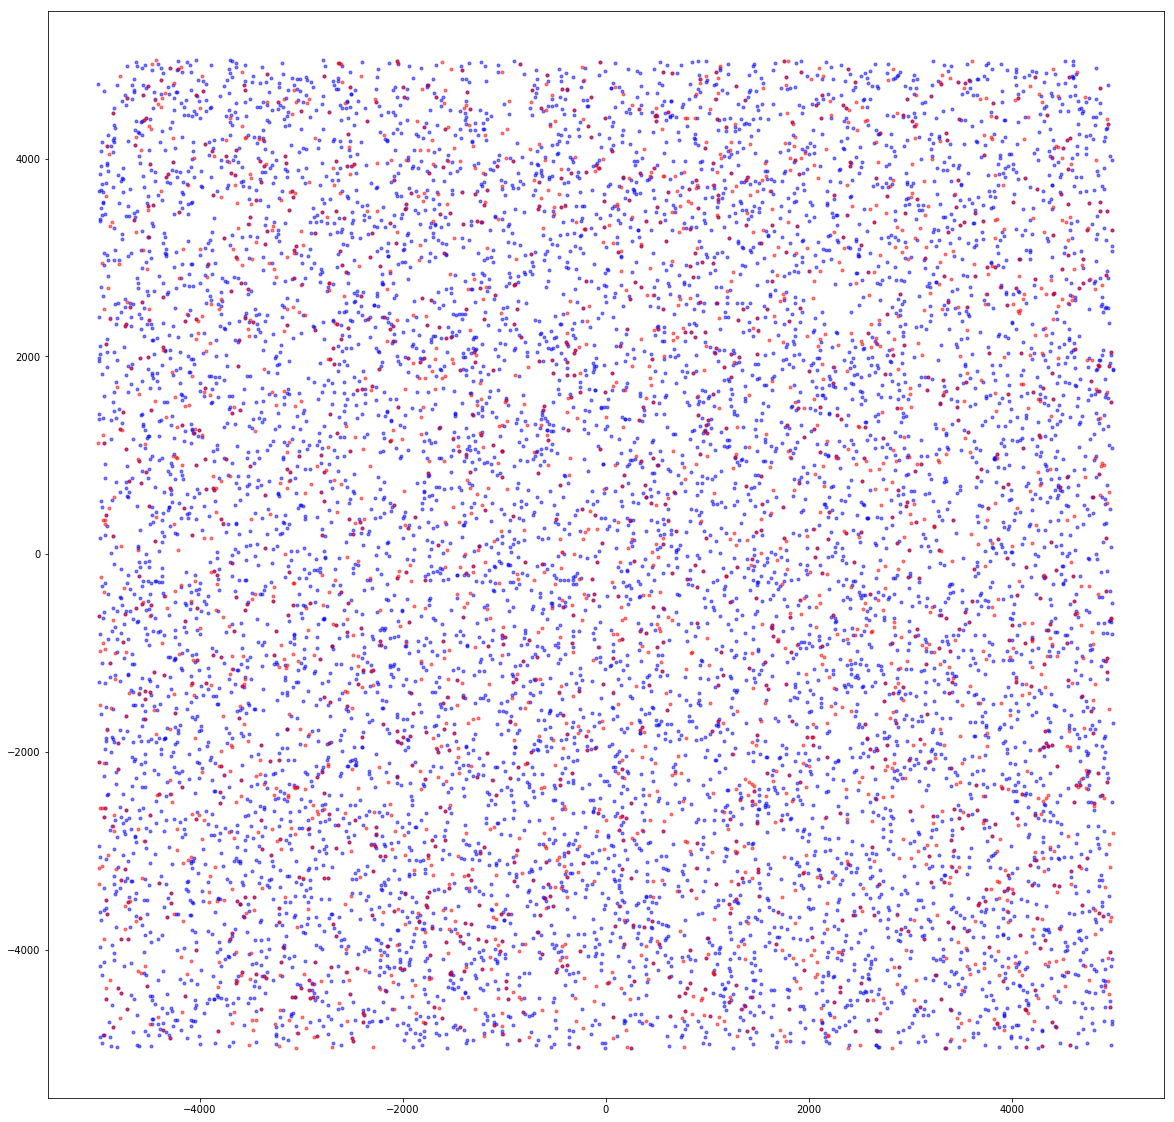

Number of Parent Clouds =  10000
Number of Born HII regions 9195
Number of Surviving Clouds =  8343
Number of Surviving HII regions 4444
Ngmc/Nhii Ratio 1.8773627362736274



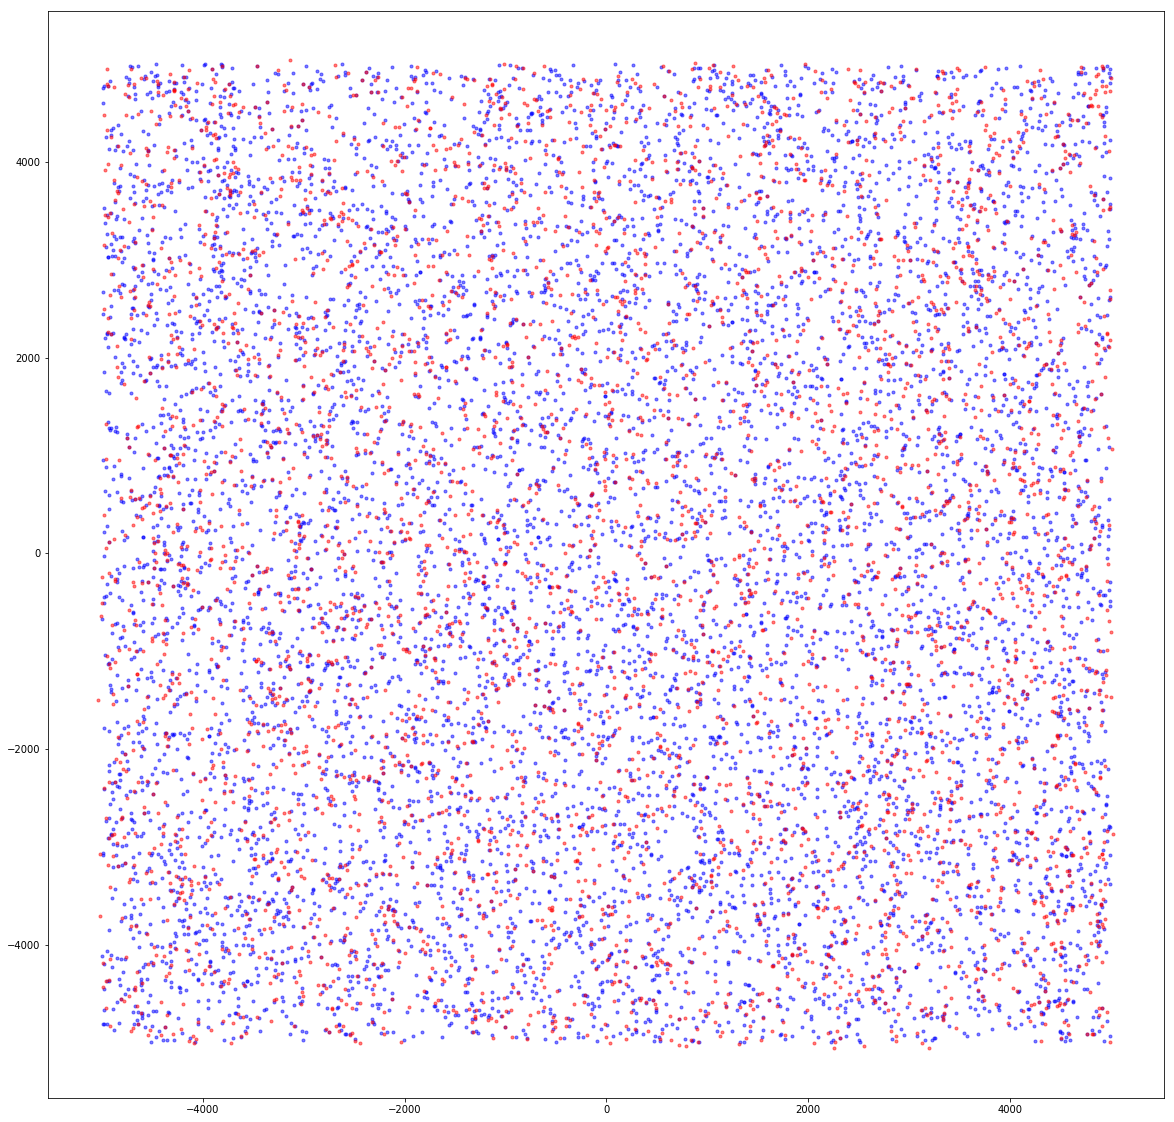

TypeError: w() missing 2 required positional arguments: 'xr' and 'yr'

In [108]:
# SFUP vs CP

xgmc1, ygmc1, xhii1, yhii1 = poop(Ng=1, vs=0, plot=True)
xgmc2, ygmc2, xhii2, yhii2 = poop(Ng=2, plot=True)

r1, w1 = w(xgmc1, ygmc1, xhii1, yhii1)
r2, w2 = w(xgmc2, ygmc2, xhii2, yhii2)

fig3, ax3 = plt.subplots(figsize=(12, 10))
ax3.plot(r1, w1, '-o', label='NSFUP')
ax3.plot(r2, w2, '-o', label='PC')

plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
ax3.tick_params(labelsize=20)
ax3.legend(fontsize=20)
#plt.yscale('log')
plt.show()


In [5]:
# Changing Ng

xgmc1, ygmc1, xhii1, yhii1 = poop(Ng=1)
xgmc2, ygmc2, xhii2, yhii2 = poop(Ng=2)
xgmc3, ygmc3, xhii3, yhii3 = poop(Ng=3)
xgmc4, ygmc4, xhii4, yhii4 = poop(Ng=4)

r1, w1 = w(xgmc1, ygmc1, xhii1, yhii1)
r2, w2 = w(xgmc2, ygmc2, xhii2, yhii2)
r3, w3 = w(xgmc3, ygmc3, xhii3, yhii3)
r4, w4 = w(xgmc4, ygmc4, xhii4, yhii4)


Number of Parent Clouds =  10000
Number of Born HII regions 2799
Number of Surviving Clouds =  8328
Number of Surviving HII regions 2240
Ngmc/Nhii Ratio 3.717857142857143

Number of Parent Clouds =  10000
Number of Born HII regions 9181
Number of Surviving Clouds =  8385
Number of Surviving HII regions 4467
Ngmc/Nhii Ratio 1.8770987239758228

Number of Parent Clouds =  10000
Number of Born HII regions 15840
Number of Surviving Clouds =  8300
Number of Surviving HII regions 6784
Ngmc/Nhii Ratio 1.2234669811320755

Number of Parent Clouds =  10000
Number of Born HII regions 22083
Number of Surviving Clouds =  8291
Number of Surviving HII regions 8882
Ngmc/Nhii Ratio 0.9334609322224724



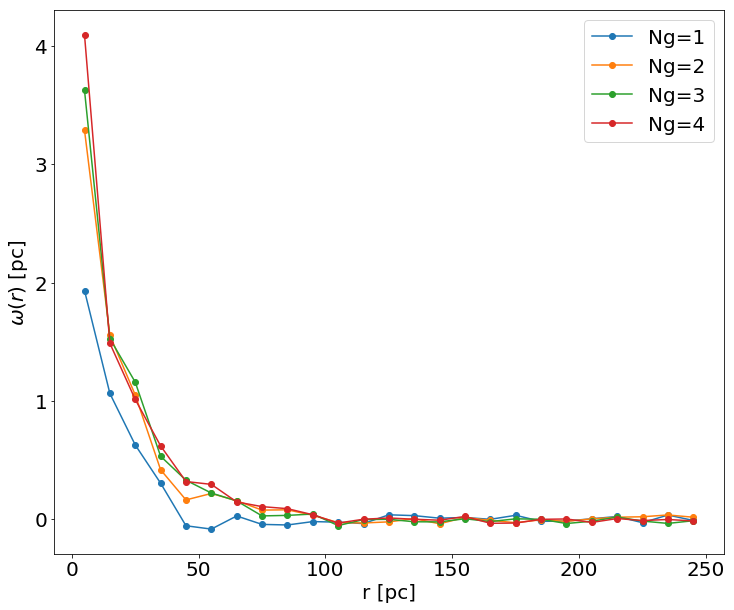

In [6]:
fig3, ax3 = plt.subplots(figsize=(12, 10))
ax3.plot(r1, w1, '-o', label='Ng=1')
ax3.plot(r2, w2, '-o', label='Ng=2')
ax3.plot(r3, w3, '-o', label='Ng=3')
ax3.plot(r4, w4, '-o', label='Ng=4')

plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
ax3.tick_params(labelsize=20)
ax3.legend(fontsize=20)
#plt.yscale('log')
plt.show()

In [7]:
# Changing vs

xgmc1, ygmc1, xhii1, yhii1 = poop(vs=0)
xgmc2, ygmc2, xhii2, yhii2 = poop(vs=5)
xgmc3, ygmc3, xhii3, yhii3 = poop(vs=10)
xgmc4, ygmc4, xhii4, yhii4 = poop(vs=20)

r1, w1 = w(xgmc1, ygmc1, xhii1, yhii1)
r2, w2 = w(xgmc2, ygmc2, xhii2, yhii2)
r3, w3 = w(xgmc3, ygmc3, xhii3, yhii3)
r4, w4 = w(xgmc4, ygmc4, xhii4, yhii4)



Number of Parent Clouds =  10000
Number of Born HII regions 9221
Number of Surviving Clouds =  8328
Number of Surviving HII regions 5514
Ngmc/Nhii Ratio 1.5103373231773667

Number of Parent Clouds =  10000
Number of Born HII regions 9031
Number of Surviving Clouds =  8376
Number of Surviving HII regions 3280
Ngmc/Nhii Ratio 2.553658536585366

Number of Parent Clouds =  10000
Number of Born HII regions 9253
Number of Surviving Clouds =  8313
Number of Surviving HII regions 4493
Ngmc/Nhii Ratio 1.8502114400178056

Number of Parent Clouds =  10000
Number of Born HII regions 9283
Number of Surviving Clouds =  8257
Number of Surviving HII regions 5067
Ngmc/Nhii Ratio 1.6295638444839156



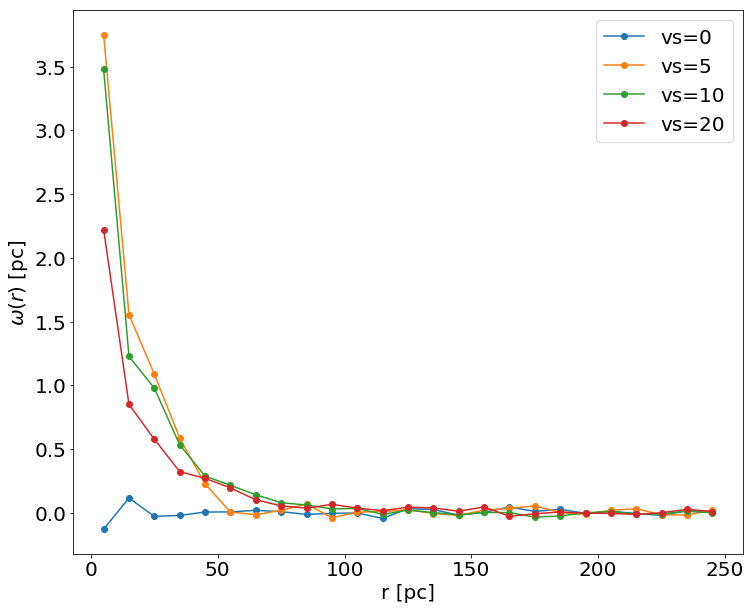

In [8]:
fig3, ax3 = plt.subplots(figsize=(12, 10))
ax3.plot(r1, w1, '-o', label='vs=0')
ax3.plot(r2, w2, '-o', label='vs=5')
ax3.plot(r3, w3, '-o', label='vs=10')
ax3.plot(r4, w4, '-o', label='vs=20')

plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
ax3.tick_params(labelsize=20)
ax3.legend(fontsize=20)
#plt.yscale('log')
plt.show()



In [9]:
# Changing l

xgmc1, ygmc1, xhii1, yhii1 = poop(l=50)
xgmc2, ygmc2, xhii2, yhii2 = poop(l=100)
xgmc3, ygmc3, xhii3, yhii3 = poop(l=200)
xgmc4, ygmc4, xhii4, yhii4 = poop(l=500)

r1, w1 = w(xgmc1, ygmc1, xhii1, yhii1)
r2, w2 = w(xgmc2, ygmc2, xhii2, yhii2)
r3, w3 = w(xgmc3, ygmc3, xhii3, yhii3)
r4, w4 = w(xgmc4, ygmc4, xhii4, yhii4)



Number of Parent Clouds =  40000
Number of Born HII regions 36776
Number of Surviving Clouds =  33327
Number of Surviving HII regions 17859
Ngmc/Nhii Ratio 1.8661179237359315

Number of Parent Clouds =  10000
Number of Born HII regions 9145
Number of Surviving Clouds =  8375
Number of Surviving HII regions 4442
Ngmc/Nhii Ratio 1.885411976587123

Number of Parent Clouds =  2500
Number of Born HII regions 2373
Number of Surviving Clouds =  2064
Number of Surviving HII regions 1145
Ngmc/Nhii Ratio 1.8026200873362446

Number of Parent Clouds =  400
Number of Born HII regions 366
Number of Surviving Clouds =  330
Number of Surviving HII regions 170
Ngmc/Nhii Ratio 1.9411764705882353



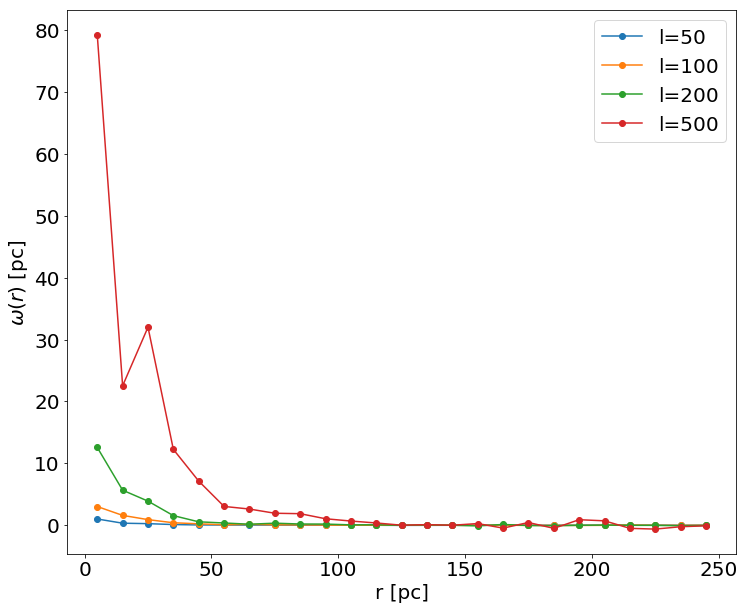

In [10]:
fig3, ax3 = plt.subplots(figsize=(12, 10))
ax3.plot(r1, w1, '-o', label='l=50')
ax3.plot(r2, w2, '-o', label='l=100')
ax3.plot(r3, w3, '-o', label='l=200')
ax3.plot(r4, w4, '-o', label='l=500')

plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
ax3.tick_params(labelsize=20)
ax3.legend(fontsize=20)
#plt.yscale('log')
plt.show()



In [11]:
# Changing tc

xgmc1, ygmc1, xhii1, yhii1 = poop(tc=10)
xgmc2, ygmc2, xhii2, yhii2 = poop(tc=30)
xgmc3, ygmc3, xhii3, yhii3 = poop(tc=60)
xgmc4, ygmc4, xhii4, yhii4 = poop(tc=120)

r1, w1 = w(xgmc1, ygmc1, xhii1, yhii1)
r2, w2 = w(xgmc2, ygmc2, xhii2, yhii2)
r3, w3 = w(xgmc3, ygmc3, xhii3, yhii3)
r4, w4 = w(xgmc4, ygmc4, xhii4, yhii4)




Number of Parent Clouds =  10000
Number of Born HII regions 14427
Number of Surviving Clouds =  6181
Number of Surviving HII regions 10094
Ngmc/Nhii Ratio 0.6123439667128987

Number of Parent Clouds =  10000
Number of Born HII regions 9125
Number of Surviving Clouds =  8333
Number of Surviving HII regions 4424
Ngmc/Nhii Ratio 1.8835895117540686

Number of Parent Clouds =  10000
Number of Born HII regions 7276
Number of Surviving Clouds =  9081
Number of Surviving HII regions 2394
Ngmc/Nhii Ratio 3.793233082706767

Number of Parent Clouds =  10000
Number of Born HII regions 6180
Number of Surviving Clouds =  9554
Number of Surviving HII regions 1255
Ngmc/Nhii Ratio 7.612749003984064



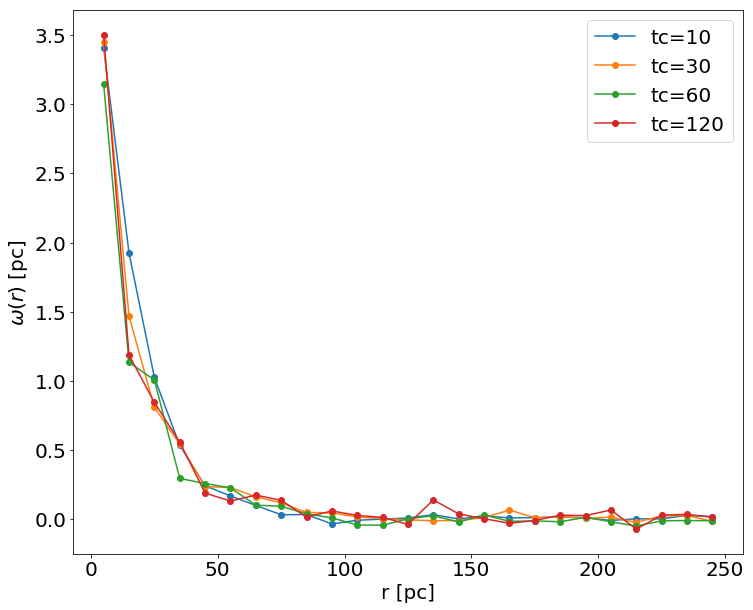

In [12]:
fig3, ax3 = plt.subplots(figsize=(12, 10))
ax3.plot(r1, w1, '-o', label='tc=10')
ax3.plot(r2, w2, '-o', label='tc=30')
ax3.plot(r3, w3, '-o', label='tc=60')
ax3.plot(r4, w4, '-o', label='tc=120')

plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
ax3.tick_params(labelsize=20)
ax3.legend(fontsize=20)
#plt.yscale('log')
plt.show()



In [13]:
# Changing tfb

xgmc1, ygmc1, xhii1, yhii1 = poop(tfb=1)
xgmc2, ygmc2, xhii2, yhii2 = poop(tfb=2)
xgmc3, ygmc3, xhii3, yhii3 = poop(tfb=4)
xgmc4, ygmc4, xhii4, yhii4 = poop(tfb=8)

r1, w1 = w(xgmc1, ygmc1, xhii1, yhii1)
r2, w2 = w(xgmc2, ygmc2, xhii2, yhii2)
r3, w3 = w(xgmc3, ygmc3, xhii3, yhii3)
r4, w4 = w(xgmc4, ygmc4, xhii4, yhii4)



Number of Parent Clouds =  10000
Number of Born HII regions 8899
Number of Surviving Clouds =  7680
Number of Surviving HII regions 4077
Ngmc/Nhii Ratio 1.88373804267844

Number of Parent Clouds =  10000
Number of Born HII regions 8840
Number of Surviving Clouds =  7895
Number of Surviving HII regions 4229
Ngmc/Nhii Ratio 1.8668716008512651

Number of Parent Clouds =  10000
Number of Born HII regions 9274
Number of Surviving Clouds =  8312
Number of Surviving HII regions 4503
Ngmc/Nhii Ratio 1.8458805240950478

Number of Parent Clouds =  10000
Number of Born HII regions 9763
Number of Surviving Clouds =  9365
Number of Surviving HII regions 5086
Ngmc/Nhii Ratio 1.8413291388124262



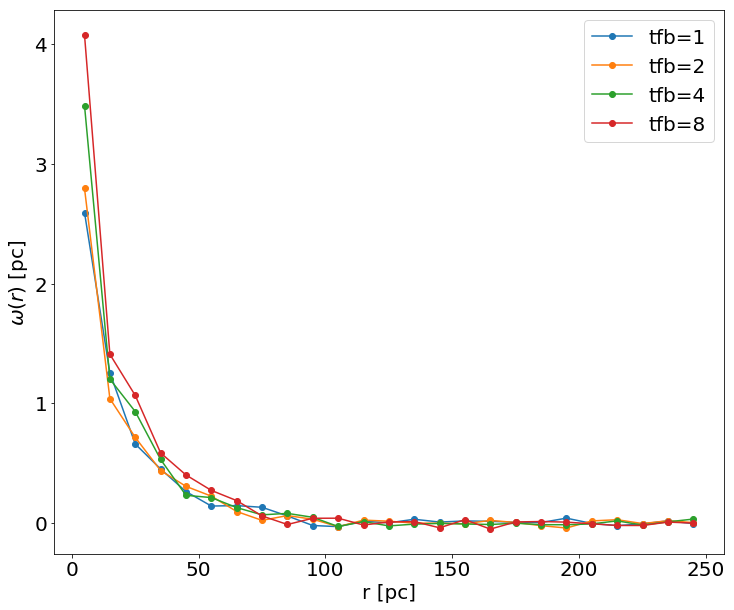

In [14]:
fig3, ax3 = plt.subplots(figsize=(12, 10))
ax3.plot(r1, w1, '-o', label='tfb=1')
ax3.plot(r2, w2, '-o', label='tfb=2')
ax3.plot(r3, w3, '-o', label='tfb=4')
ax3.plot(r4, w4, '-o', label='tfb=8')

plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
ax3.tick_params(labelsize=20)
ax3.legend(fontsize=20)
#plt.yscale('log')
plt.show()



In [15]:
# Changing ts

xgmc1, ygmc1, xhii1, yhii1 = poop(ts=5)
xgmc2, ygmc2, xhii2, yhii2 = poop(ts=10)
xgmc3, ygmc3, xhii3, yhii3 = poop(ts=15)
xgmc4, ygmc4, xhii4, yhii4 = poop(ts=20)

r1, w1 = w(xgmc1, ygmc1, xhii1, yhii1)
r2, w2 = w(xgmc2, ygmc2, xhii2, yhii2)
r3, w3 = w(xgmc3, ygmc3, xhii3, yhii3)
r4, w4 = w(xgmc4, ygmc4, xhii4, yhii4)




Number of Parent Clouds =  10000
Number of Born HII regions 7454
Number of Surviving Clouds =  9670
Number of Surviving HII regions 1902
Ngmc/Nhii Ratio 5.084121976866457

Number of Parent Clouds =  10000
Number of Born HII regions 9087
Number of Surviving Clouds =  8314
Number of Surviving HII regions 4481
Ngmc/Nhii Ratio 1.855389422004017

Number of Parent Clouds =  10000
Number of Born HII regions 10629
Number of Surviving Clouds =  7286
Number of Surviving HII regions 6430
Ngmc/Nhii Ratio 1.1331259720062208

Number of Parent Clouds =  10000
Number of Born HII regions 11647
Number of Surviving Clouds =  6454
Number of Surviving HII regions 7847
Ngmc/Nhii Ratio 0.8224799286351472



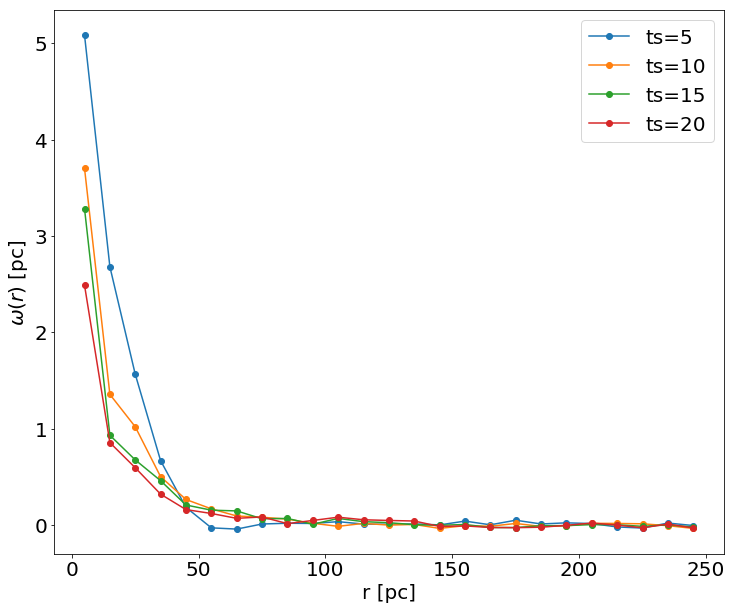

In [16]:
fig3, ax3 = plt.subplots(figsize=(12, 10))
ax3.plot(r1, w1, '-o', label='ts=5')
ax3.plot(r2, w2, '-o', label='ts=10')
ax3.plot(r3, w3, '-o', label='ts=15')
ax3.plot(r4, w4, '-o', label='ts=20')

plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
ax3.tick_params(labelsize=20)
ax3.legend(fontsize=20)
#plt.yscale('log')
plt.show()



In [17]:
# Changing rc

xgmc1, ygmc1, xhii1, yhii1 = poop(rc=5)
xgmc2, ygmc2, xhii2, yhii2 = poop(rc=10)
xgmc3, ygmc3, xhii3, yhii3 = poop(rc=25)
xgmc4, ygmc4, xhii4, yhii4 = poop(rc=50)

r1, w1 = w(xgmc1, ygmc1, xhii1, yhii1)
r2, w2 = w(xgmc2, ygmc2, xhii2, yhii2)
r3, w3 = w(xgmc3, ygmc3, xhii3, yhii3)
r4, w4 = w(xgmc4, ygmc4, xhii4, yhii4)



Number of Parent Clouds =  10000
Number of Born HII regions 9221
Number of Surviving Clouds =  8328
Number of Surviving HII regions 5236
Ngmc/Nhii Ratio 1.5905271199388846

Number of Parent Clouds =  10000
Number of Born HII regions 9031
Number of Surviving Clouds =  8376
Number of Surviving HII regions 4965
Ngmc/Nhii Ratio 1.6870090634441088

Number of Parent Clouds =  10000
Number of Born HII regions 9253
Number of Surviving Clouds =  8313
Number of Surviving HII regions 4239
Ngmc/Nhii Ratio 1.9610757254069355

Number of Parent Clouds =  10000
Number of Born HII regions 9283
Number of Surviving Clouds =  8257
Number of Surviving HII regions 2860
Ngmc/Nhii Ratio 2.8870629370629373



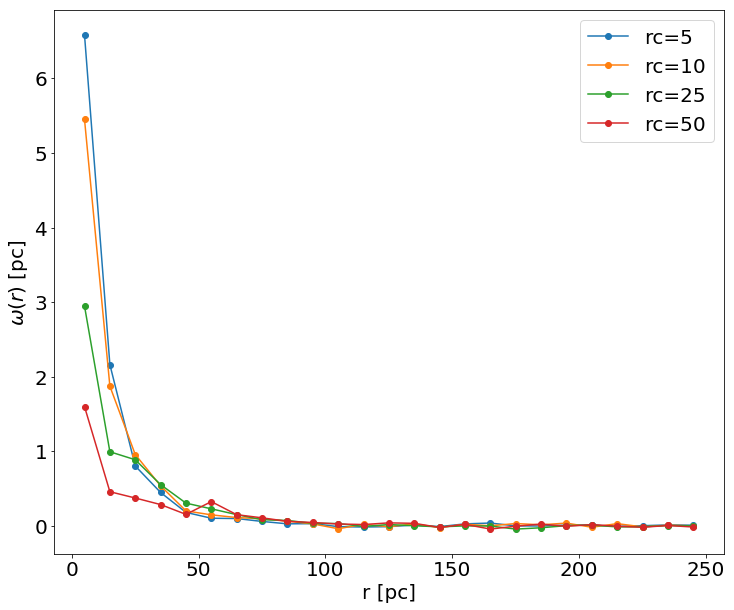

In [18]:
fig3, ax3 = plt.subplots(figsize=(12, 10))
ax3.plot(r1, w1, '-o', label='rc=5')
ax3.plot(r2, w2, '-o', label='rc=10')
ax3.plot(r3, w3, '-o', label='rc=25')
ax3.plot(r4, w4, '-o', label='rc=50')

plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
ax3.tick_params(labelsize=20)
ax3.legend(fontsize=20)
#plt.yscale('log')
plt.show()




# Test on Real Galaxy

In [6]:
# Calculate 2-point Corss-Correlation Function between GMCs and HII regions given (xgmc, ygmc) and (xhii, yhii)
# but withing a circular field for the random points

def wr(x1, y1, x2, y2, rmin=0, rmax=250, dr=10, Nr=10000):

    # Make random catalog
    rad1=np.sqrt(x1**2+y1**2)
    rad2=np.sqrt(x2**2+y2**2)
    rmax1=np.max(rad1)
    rmax2=np.max(rad2)
    rmaxsel=np.max([rmax1,rmax2])
    np.random.seed(666)
    xr=np.random.uniform(np.min(x1), np.max(x1), Nr)
    yr=np.random.uniform(np.min(y1), np.max(y1), Nr)
    selr=np.sqrt(xr**2+yr**2)<rmaxsel
    xr=xr[selr]
    yr=yr[selr]
    
    # GMC-HII region pairs distances
#    ddarr=np.zeros(len(x1)*len(x2))
#    k=0
#    for i in range(len(x1)):
##        print(i, len(x1))
#        for j in range(len(x2)):
#            ddarr[k]=np.sqrt((x1[i]-x2[j])**2+(y1[i]-y2[j])**2)
#            k=k+1
    
    # GMC-Random pairs distances
#    drarr=np.zeros(len(x1)*len(xr))
#    k=0
#    for i in range(len(x1)):
##        print(i, len(x1))
#        for j in range(len(xr)):
#            drarr[k]=np.sqrt((x1[i]-xr[j])**2+(y1[i]-yr[j])**2)
#            k=k+1

    ddarr=cdist(np.transpose(np.array([x1,y1])), np.transpose(np.array([x2,y2]))).ravel()  
    drarr=cdist(np.transpose(np.array([x1,y1])), np.transpose(np.array([xr,yr]))).ravel()
            
    # Count pairs in distance bins       
    N1=len(x1)
    N2=len(x2)
    bins=np.arange(rmin+dr/2, rmax, dr)
    dd0=np.zeros(len(bins))
    dr0=np.zeros(len(bins))
    for i in range(len(bins)):
        dd0[i]=len(ddarr[(ddarr>bins[i]-dr/2)*(ddarr<=bins[i]+dr/2)])
        dr0[i]=len(drarr[(drarr>bins[i]-dr/2)*(drarr<=bins[i]+dr/2)])

    # Normalize pair counts and compute cross-correlation function
    dd=dd0/N1/N2
    dr=dr0/N1/Nr
    omega=dd/dr-1
    
#    fig2, ax2 = plt.subplots(figsize=(12, 10))
#    ax2.plot(bins, omega, 'o')
#    plt.show()
    
    return (bins, omega, xr, yr)


[70.4938034   1.41774656 33.81357855 16.96988167 46.18805457 44.44017114]


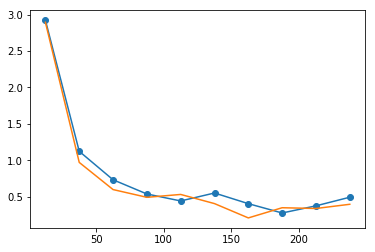

In [13]:
# The right way to do this is to fit w(r) with the poopxy model
# Lets try first with a Levemberg-Marquadt minimization

from scipy.optimize import curve_fit


def func(r, tc0, tfb0, ts0, Ng0, vs0, rc0):
    xgmc, ygmc, xhii, yhii = poopxy(x1[sel1], y1[sel1], tc=tc0, tfb=tfb0, ts=ts0, Ng=Ng0, vs=vs0, rc=rc0)
    rout, wout = w(xgmc, ygmc, xhii, yhii, dr=25)
    return wout

#p0=np.array([20, 3, 12, 1.7, 30, 20])
p0=np.array([ 60.03085827,   6.36745156,  19.99261724,   9.07866929, 29.62534059, 0])


#popt, pcov = curve_fit(func, r0, w0, p0, bounds=((0, 0, 3, 1, 0, 0),(1e3, 1e2, 15, 10, 100, 200)))
#popt, pcov = curve_fit(func, r0, w0, p0, sigma=np.zeros(len(w0))+0.5, bounds=((0, 0, 3, 1, 0, 0),(1e3, 1e2, 15, 10, 100, 200)), verbose=2, method='trf', diff_step=1)

popt, pcov = curve_fit(func, r0, w0, p0, sigma=np.zeros(len(w0))+0.5, method='lm', epsfcn=2)





print(popt)

guess=func(r0, p0[0], p0[1], p0[2], p0[3], p0[4], p0[5])
best=func(r0, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])
plt.plot(r0, w0, '-o')
#plt.plot(r0, guess)
plt.plot(r0, best)
plt.show()

#[42.59812706  0.6522959  20.91218678  1.90094499 42.64361321  6.6531521 ]

In [14]:
# Actually the right way to do this is with an MCMC

import emcee


def log_prob(p):
    xgmc, ygmc, xhii, yhii = poopxy(x1[sel1], y1[sel1], tc=p[0], tfb=p[1], ts=p[2], Ng=p[3], vs=p[4], rc=p[5])
#    print(len(xgmc), len(xhii))
#    print(len(xgmc)<=1)
#    print(len(xhii)<=1)
#    print((len(xgmc)<=1) or (len(xhii)<=1))
    if (len(xgmc)<=1) or (len(xhii)<=1):
#        print("fail1")
        return -np.inf
    
    
    rout, wout = w(xgmc, ygmc, xhii, yhii, dr=25)
    res=w0-wout
    sig=np.zeros(len(w0))+0.5
    prob=1/(2*np.pi*sig**2)*np.exp(-0.5*(res/sig)**2)
    logp=np.sum(np.log(prob))
    if not np.isfinite(logp):
#        print("fail2")
        return -np.inf
    return logp

ndim=6
nwalkers=16

p0 = np.zeros((nwalkers, ndim))
p0[:,0]=np.random.uniform(10, 100, nwalkers)
p0[:,1]=np.random.uniform(1, 10, nwalkers)
p0[:,2]=np.random.uniform(0, 30, nwalkers)
p0[:,3]=np.random.uniform(1, 10, nwalkers)
p0[:,4]=np.random.uniform(0, 50, nwalkers)
p0[:,5]=np.random.uniform(0, 100, nwalkers)


#for i in range(nwalkers):
#    print(p0[i,:])
#    print(log_prob(p0[i,:]))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)


In [15]:
sampler.reset()
Nmc=500
t0=time.time()
state = sampler.run_mcmc(p0,Nmc)
dt=time.time()-t0
print("Run Time, s/sample = ",dt, dt/Nmc)

/Users/gblancm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/gblancm/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/gblancm/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Run Time, s/sample =  6455.6542892456055 12.91130857849121


(32, 500, 6)


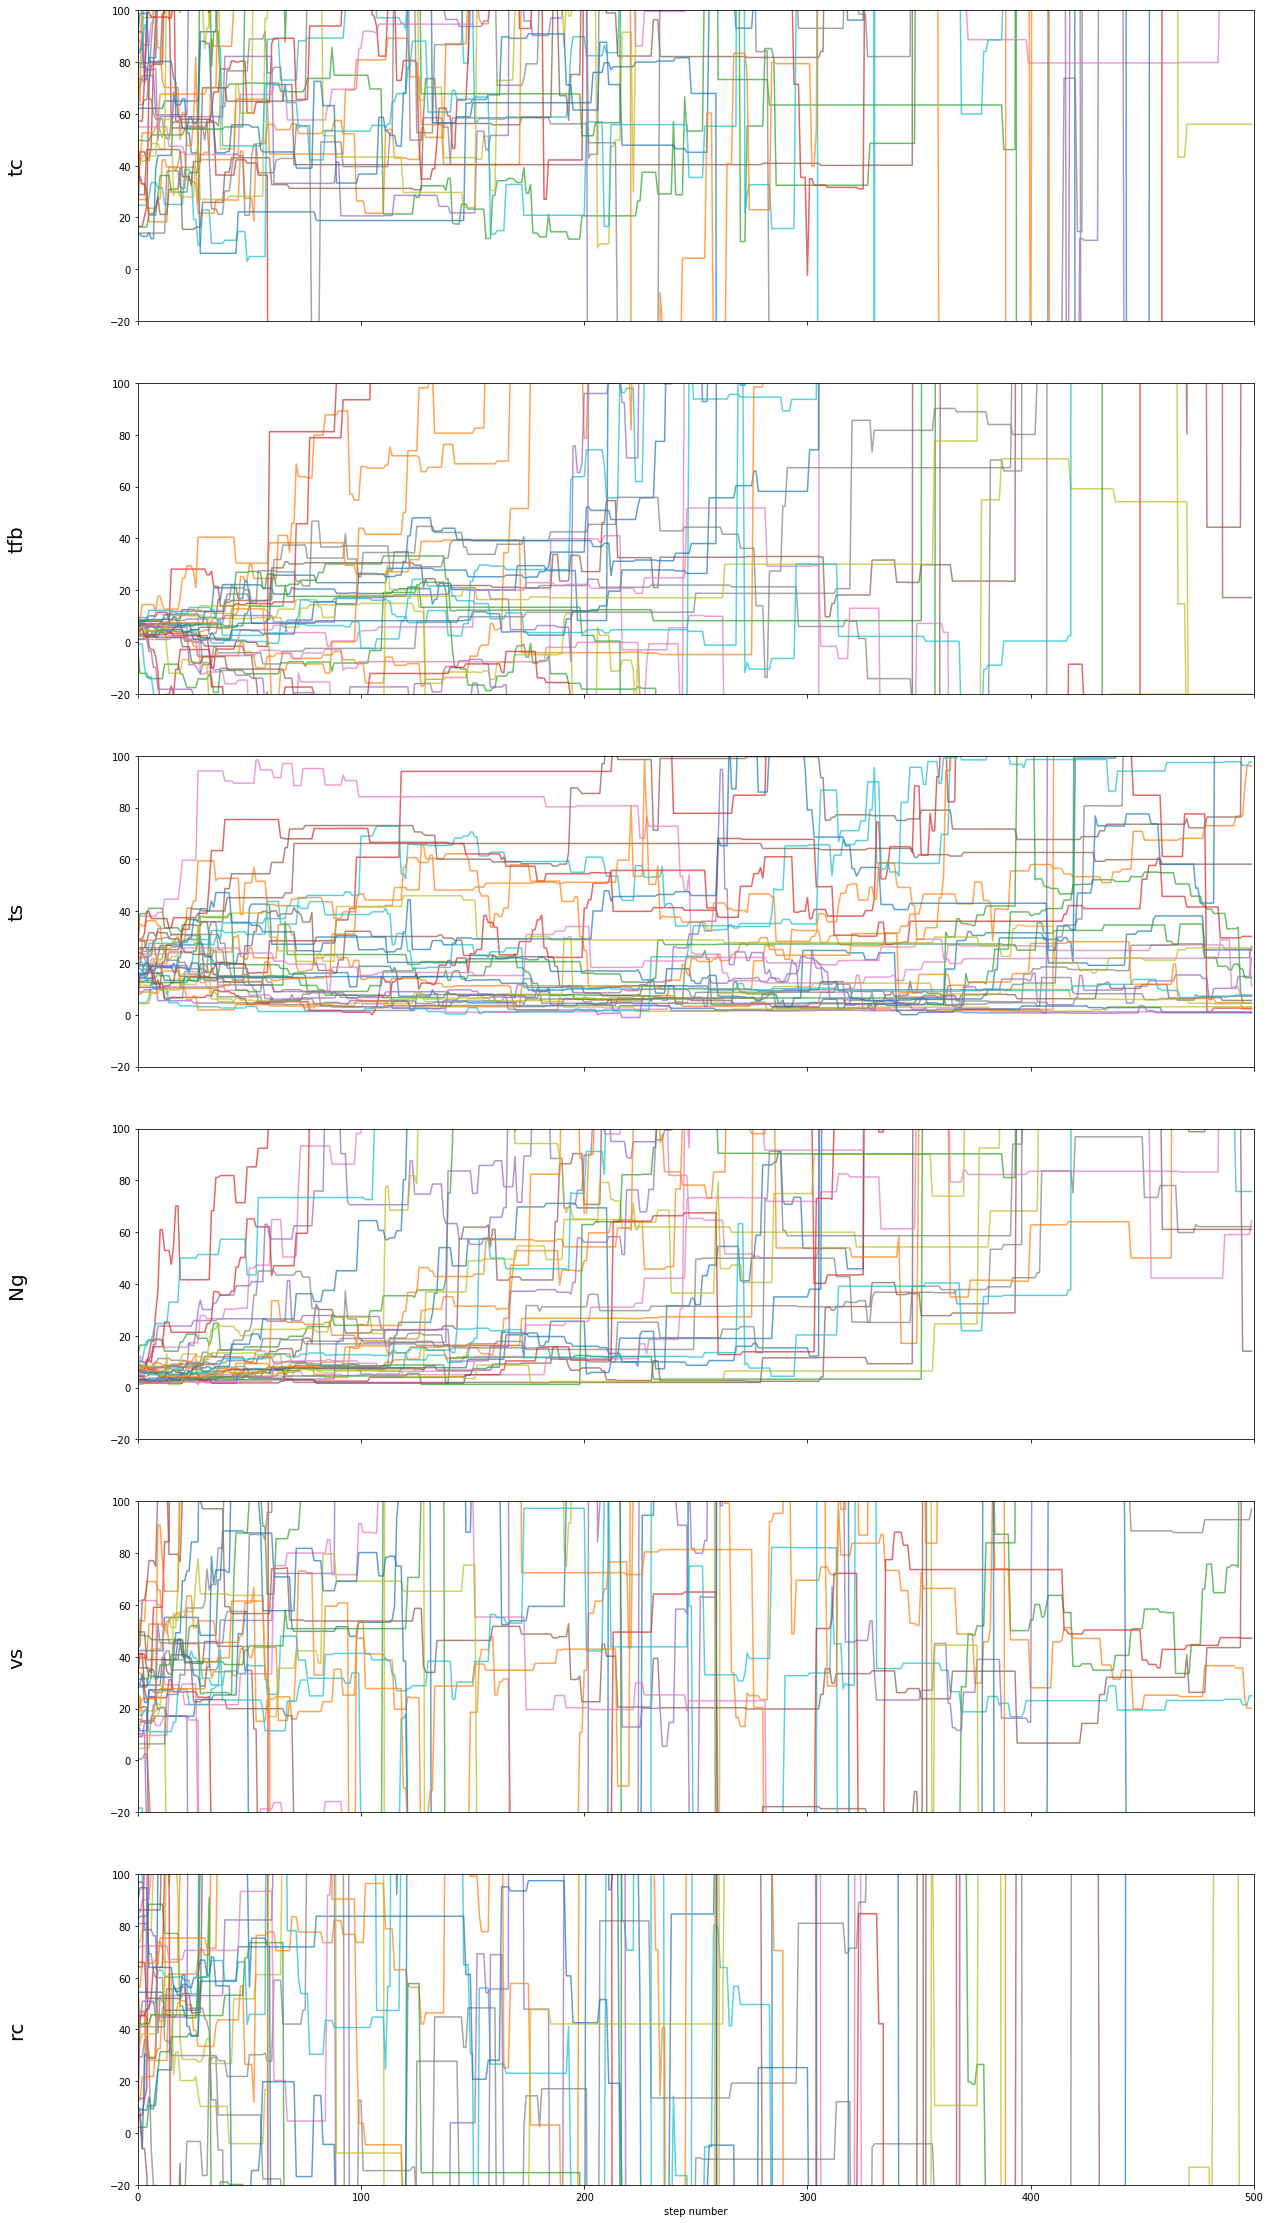

In [16]:
fig, axes = plt.subplots(6, figsize=(20, 40), sharex=True)
samples = sampler.chain
print(np.shape(samples))
labels = ["tc", "tfb", "ts", "Ng", "vs", "rc"]
for i in range(ndim):
    ax = axes[i]
    for j in range(nwalkers):
        ax.plot(samples[j, :, i], "-", alpha=0.7)
    ax.set_xlim(0, Nmc)
    ax.set_ylim(-20,100)
    ax.set_ylabel(labels[i], fontsize=20)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [17]:
logp=sampler.lnprobability
np.shape(logp)
maxlogp=np.max(logp)
selbest=np.where(logp == maxlogp)
bestwalk=selbest[0][0]
bestsamp=selbest[1][0]
pbest=samples[bestwalk, bestsamp, :]
pbest

array([ 93.06458817,   5.99368601,   4.53459089,  31.23377434,
       208.30592057,  81.03754979])

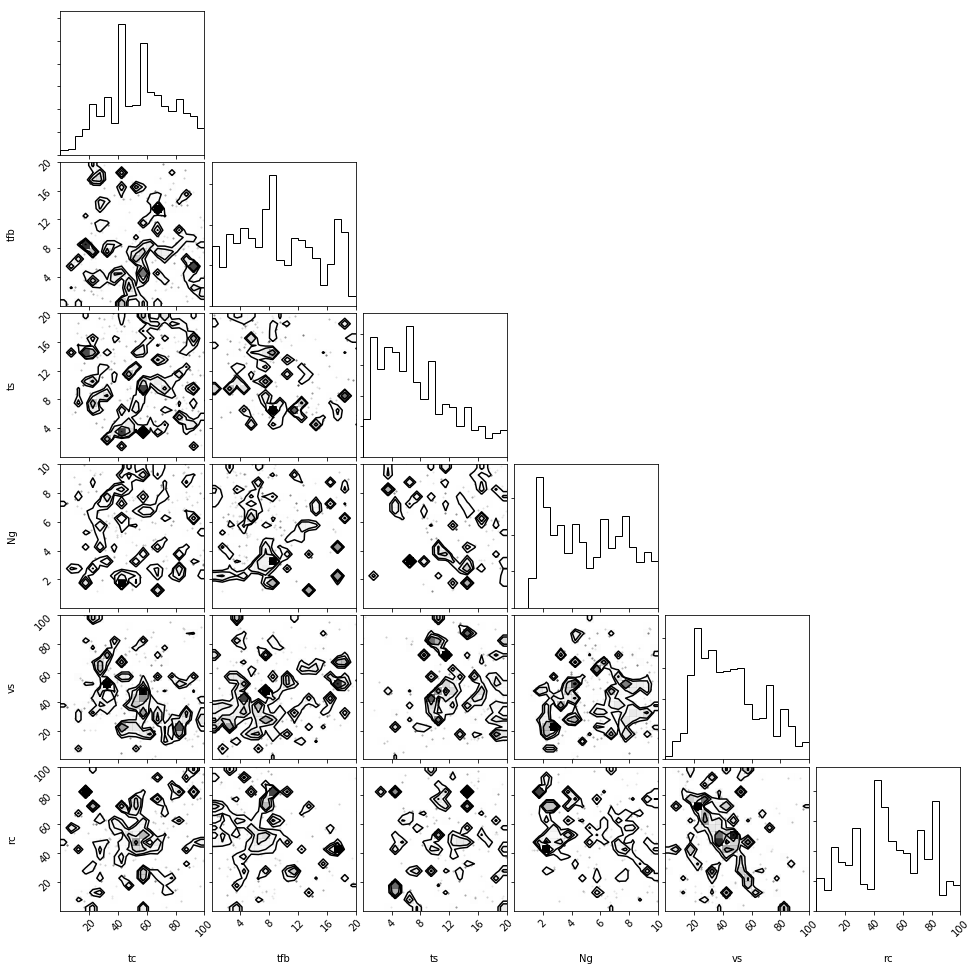

In [18]:
import corner
flat_samples=sampler.flatchain
np.shape(flat_samples)
lables=["tc", "tfb", "ts", "Ng", "vs", "rc"]
fig = corner.corner(flat_samples, labels=labels, range=[(0,100), (0,20), (0,20), (0,10), (0, 100), (0,100)]);

Number of Parent Clouds =  10000
Number of Born HII regions 2799
Number of Surviving Clouds =  8328
Number of Surviving HII regions 2799
Ngmc/Nhii Ratio 2.97534833869239

Number of Parent Clouds =  977
Number of Born HII regions 15531
Number of Surviving Clouds =  977
Number of Surviving HII regions 1354
Ngmc/Nhii Ratio 0.7215657311669128



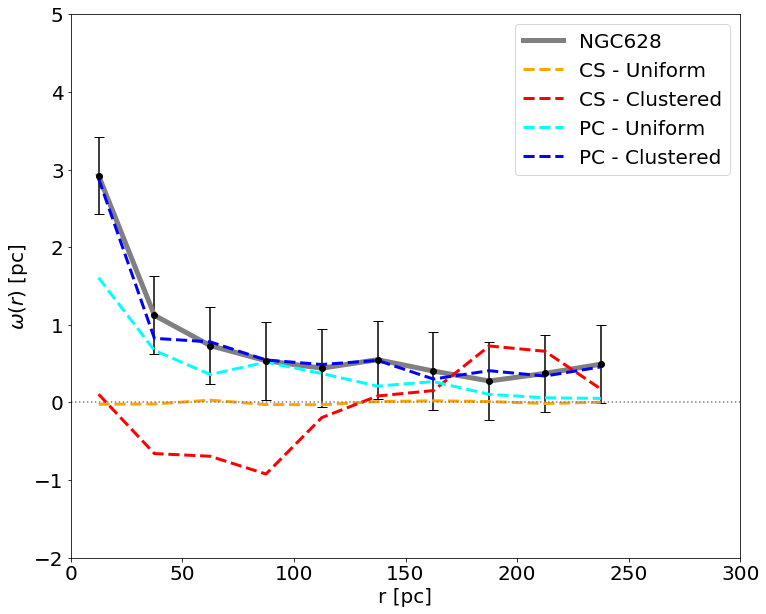

In [20]:
# Plots

#p0=np.array([ 60.03085827,   6.36745156,  19.99261724,   9.07866929, 29.62534059, 0])
#p0=np.array([ 60, 6, 20, 3, 30, 0])
#p0=np.array([64.18000076,  6.45526352, 30.83223531,  4.50165515, 38.65771703, 87.0258404 ])

p0=pbest


# SFUP model with random uniform cloud positions 
#xgmc1, ygmc1, xhii1, yhii1 = poop(tc=p0[0], tfb=p0[1], ts=p0[2], Ng=1, vs=0, rc=p0[5], l=300)
xgmc1, ygmc1, xhii1, yhii1 = poop(Ng=1, vs=0)
r1, w1 = w(xgmc1, ygmc1, xhii1, yhii1, dr=25)

# SFUP model with cloud positions at galaxy GMC positions
#xgmc2, ygmc2, xhii2, yhii2 = poopxy(x1[sel1], y1[sel1], tc=p0[0], tfb=p0[1], ts=p0[2], Ng=1, vs=0, rc=p0[5])
xgmc2, ygmc2, xhii2, yhii2 = poopxy(x1[sel1], y1[sel1], Ng=1, vs=0)
r2, w2 = w(xgmc2, ygmc2, xhii2, yhii2, dr=25)

# PC model with random uniform cloud positions 
xgmc3, ygmc3, xhii3, yhii3 = poop(tc=p0[0], tfb=p0[1], ts=p0[2], Ng=p0[3], vs=p0[4], rc=p0[5], l=320)
r3, w3 = w(xgmc3, ygmc3, xhii3, yhii3, dr=25)

# PC model with cloud positions at galaxy GMC positions
xgmc4, ygmc4, xhii4, yhii4 = poopxy(x1[sel1], y1[sel1], tfb=p0[1], ts=p0[2], Ng=p0[3], vs=p0[4], rc=p0[5])
r4, w4 = w(xgmc4, ygmc4, xhii4, yhii4, dr=25)



fig5, ax5 = plt.subplots(figsize=(12, 10))
ax5.plot(r0, w0, '-', color='grey', label='NGC628', linewidth=5)
ax5.errorbar(r0, w0, yerr=np.zeros(len(w0))+0.5, fmt="o", color='black', capsize=5)
ax5.plot(r1, w1, '--', color='orange', label='CS - Uniform', linewidth=3)
ax5.plot(r2, w2, '--', color='red', label='CS - Clustered', linewidth=3)
ax5.plot(r3, w3, '--', color='cyan', label='PC - Uniform', linewidth=3)
ax5.plot(r4, w4, '--', color='blue', label='PC - Clustered', linewidth=3)

ax5.plot(np.zeros(10000), ':', color='grey')


plt.xlim(0, 300)
plt.ylim(-2, 5)
plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
ax5.tick_params(labelsize=20)
ax5.legend(fontsize=20)
#plt.yscale('log')
plt.show()




In [ ]:
# photometry apertures for GMCs
gmccoords=SkyCoord(ra1, dec1, frame='icrs', unit='deg')
gmcapertures=SkyCircularAperture(gmccoords, 1.* u.arcsec)

# photometry apertures for HII regions
hiicoords=SkyCoord(ra2, dec2, frame='icrs', unit='deg')
hiiapertures=SkyCircularAperture(hiicoords, 1.* u.arcsec)

# HII region photometry on CO map
hiico_phot_table = aperture_photometry(comap, hiiapertures, wcs=cowcs)

# GMC photometry on Ha map
gmcha_phot_table = aperture_photometry(hamap, gmcapertures, wcs=hawcs)


sel1 = np.isfinite(gmcha_phot_table['aperture_sum'])
sel2 = np.isfinite(hiico_phot_table['aperture_sum'])


